Loaded tickers: ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']
  Ticker  Annualized Return  Annualized Volatility  Sharpe Ratio
0   AAPL           0.383541               0.285902      1.341515
1   AMZN           0.388236               0.346528      1.120360
2   GOOG           0.257668               0.275161      0.936425
3   META           0.313224               0.401306      0.780511
4   MSFT           0.285005               0.268038      1.063302
5   NVDA           0.604070               0.459048      1.315919


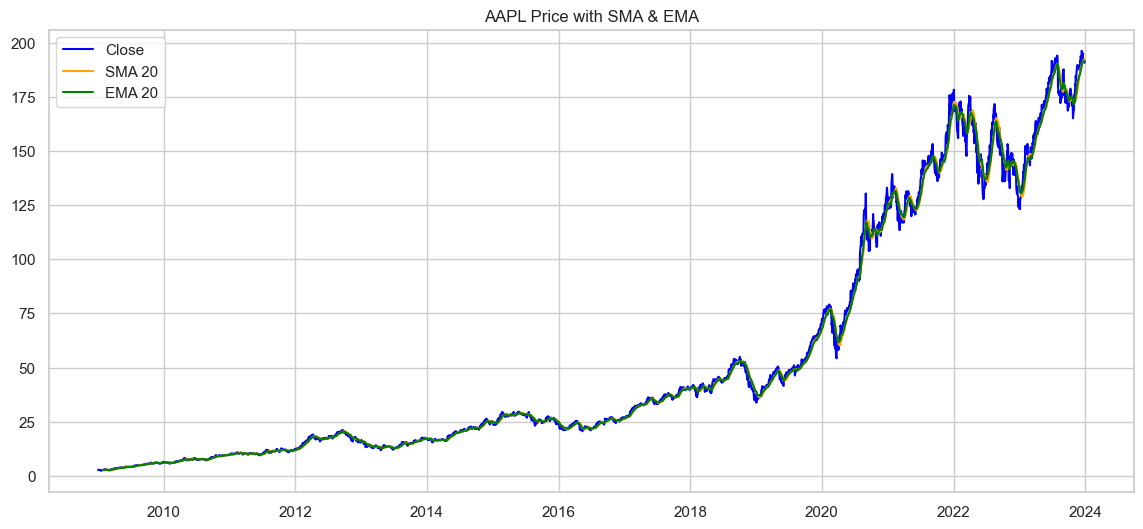

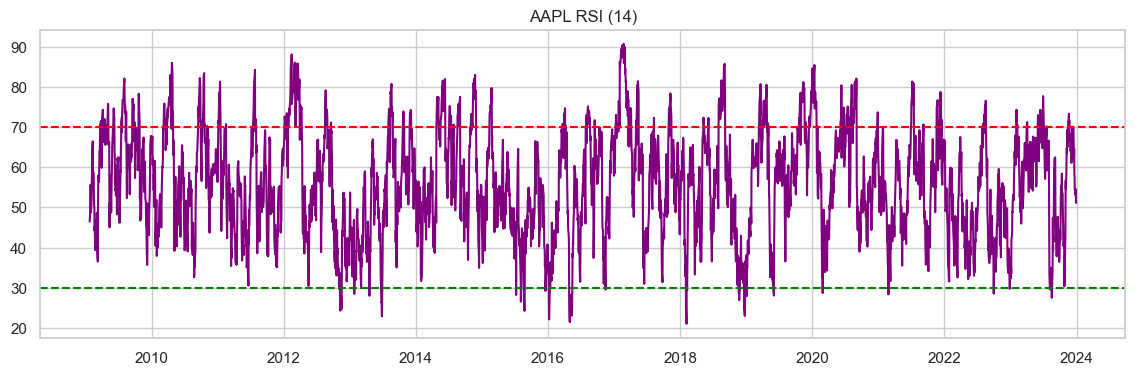

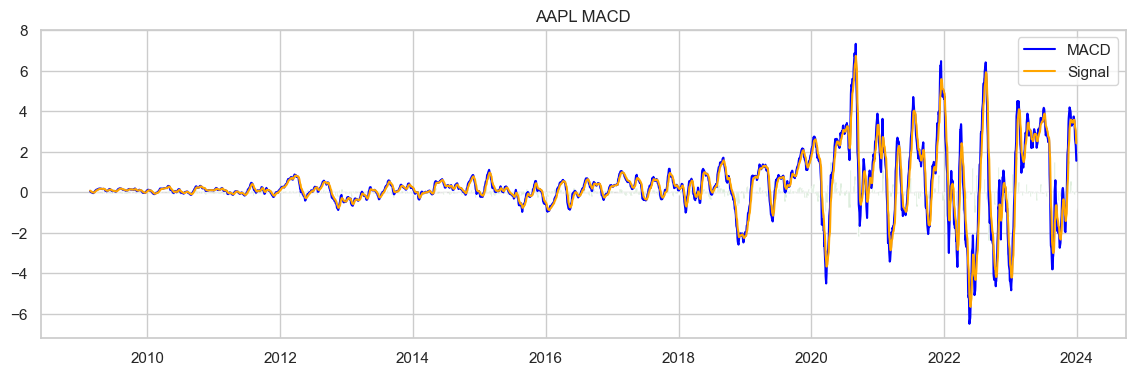

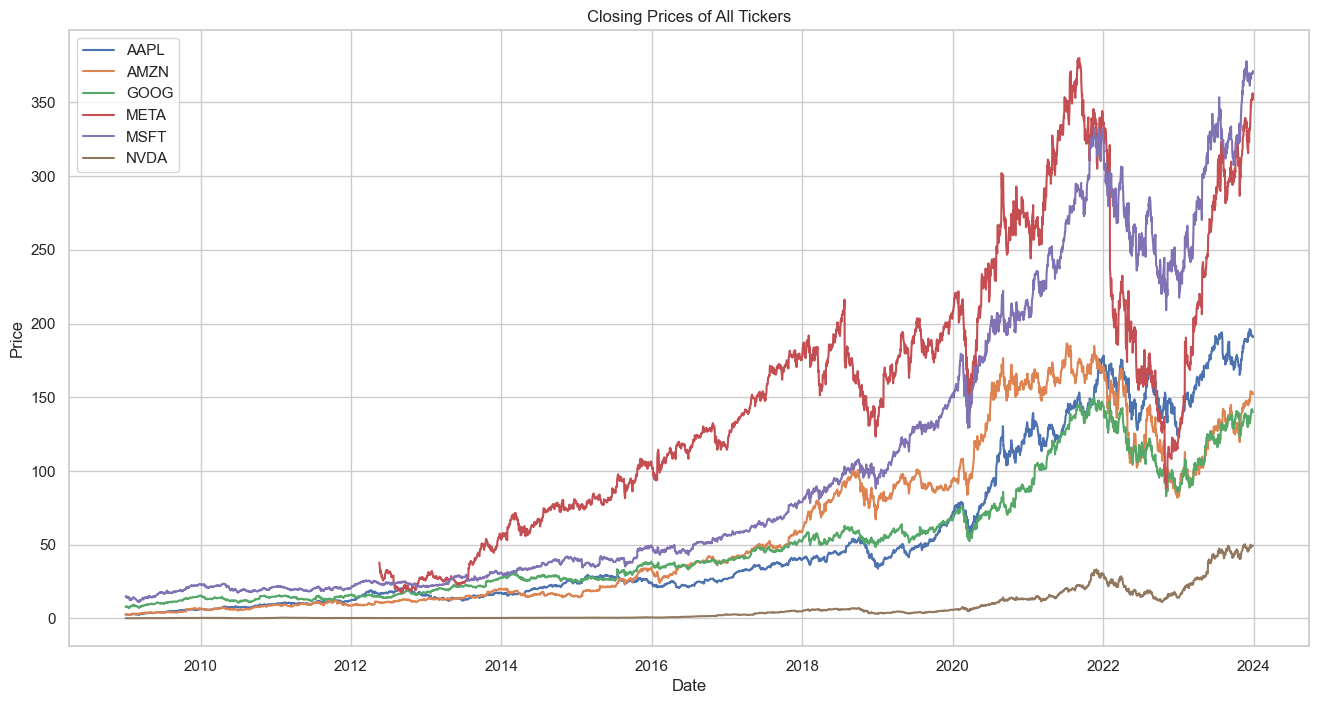

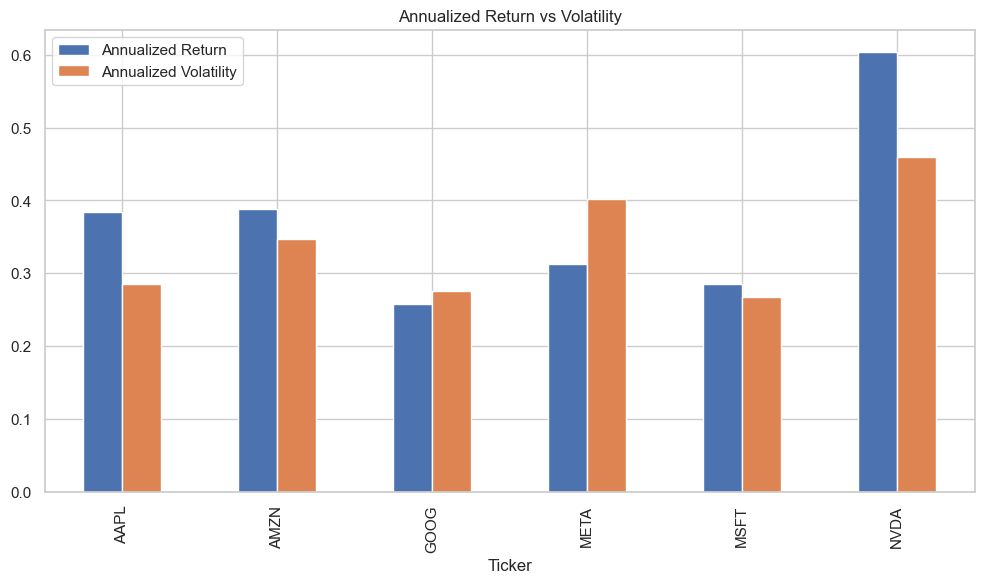

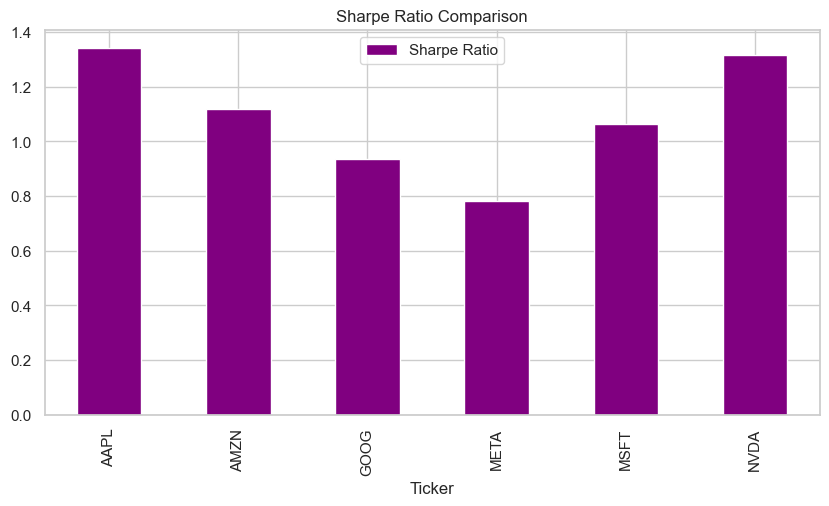

In [15]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add src folder to path for custom module
sys.path.append(r"C:\Users\gasha\OneDrive - Wollo University\Desktop\10Academy AIM 8\fnspid\src")

# Try TA-Lib
try:
    import talib
    TALIB_AVAILABLE = True
except ImportError:
    TALIB_AVAILABLE = False

# Try PyNance
try:
    import pynance as pn
    PYNANCE_AVAILABLE = True
except ImportError:
    PYNANCE_AVAILABLE = False


# Load Data
from data_load import load_csv_file

data_dir = r"C:\Users\gasha\OneDrive - Wollo University\Desktop\10Academy AIM 8\fnspid\data"
tickers = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']

data_dict = {}
for ticker in tickers:
    file_path = f"{data_dir}\\{ticker}.csv"
    df = load_csv_file(file_path)
    data_dict[ticker] = df

print("Loaded tickers:", list(data_dict.keys()))


# Apply Technical Indicators (TA-Lib)
def compute_indicators(df):
    close = df['Close']
    if TALIB_AVAILABLE:
        df['SMA_20'] = talib.SMA(close, timeperiod=20)
        df['EMA_20'] = talib.EMA(close, timeperiod=20)
        df['RSI_14'] = talib.RSI(close, timeperiod=14)
        macd, macd_signal, macd_hist = talib.MACD(close, 12, 26, 9)
    else:
        df['SMA_20'] = close.rolling(20).mean()
        df['EMA_20'] = close.ewm(span=20, adjust=False).mean()
        delta = close.diff()
        up = delta.clip(lower=0)
        down = -delta.clip(upper=0)
        roll_up = up.rolling(14).mean()
        roll_down = down.rolling(14).mean()
        rs = roll_up / roll_down.replace(0, np.nan)
        df['RSI_14'] = 100 - (100 / (1 + rs))
        ema_fast = close.ewm(span=12, adjust=False).mean()
        ema_slow = close.ewm(span=26, adjust=False).mean()
        macd = ema_fast - ema_slow
        macd_signal = macd.ewm(span=9, adjust=False).mean()
        macd_hist = macd - macd_signal
    df['MACD'] = macd
    df['MACD_signal'] = macd_signal
    df['MACD_hist'] = macd_hist
    return df

for ticker in tickers:
    data_dict[ticker] = compute_indicators(data_dict[ticker])



# Compute Financial Metrics
def compute_metrics(df):
    returns = df['Close'].pct_change().dropna()
    ann_return = (1 + returns.mean()) ** 252 - 1
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol else np.nan
    return ann_return, ann_vol, sharpe

metrics = []
for ticker in tickers:
    ann_return, ann_vol, sharpe = compute_metrics(data_dict[ticker])
    metrics.append({'Ticker': ticker, 'Annualized Return': ann_return,
                    'Annualized Volatility': ann_vol, 'Sharpe Ratio': sharpe})

metrics_df = pd.DataFrame(metrics)
print(metrics_df)



# Visualize Data
sns.set_theme(style="whitegrid")

# Example visualization for one ticker
ticker = 'AAPL'
df = data_dict[ticker]

# Price + SMA/EMA
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Close'], label='Close', color='blue')
plt.plot(df.index, df['SMA_20'], label='SMA 20', color='orange')
plt.plot(df.index, df['EMA_20'], label='EMA 20', color='green')
plt.title(f"{ticker} Price with SMA & EMA")
plt.legend()
plt.show()

# RSI
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['RSI_14'], color='purple')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title(f"{ticker} RSI (14)")
plt.show()

# MACD
plt.figure(figsize=(14, 4))
plt.plot(df.index, df['MACD'], label='MACD', color='blue')
plt.plot(df.index, df['MACD_signal'], label='Signal', color='orange')
plt.bar(df.index, df['MACD_hist'], color='green', alpha=0.5)
plt.title(f"{ticker} MACD")
plt.legend()
plt.show()


# Combined Closing Price Chart for All Tickers
plt.figure(figsize=(16, 8))
for ticker in tickers:
    plt.plot(data_dict[ticker].index, data_dict[ticker]['Close'], label=ticker)
plt.title("Closing Prices of All Tickers")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


# Comparison charts for all tickers
metrics_df.plot(x='Ticker', y=['Annualized Return', 'Annualized Volatility'], kind='bar', figsize=(12, 6))
plt.title("Annualized Return vs Volatility")
plt.show()

metrics_df.plot(x='Ticker', y='Sharpe Ratio', kind='bar', color='purple', figsize=(10, 5))
plt.title("Sharpe Ratio Comparison")
plt.show()

